In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

In [ ]:
#read in all the words
words = open('/content/drive/MyDrive/dataSet_for_practice/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
#build the vocabulary of characters and mapping to/from integers

char = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(char)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(stoi)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [ ]:
# build the dataset
block_size = 3 #context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      #80%
Xdev, Ydev = build_dataset(words[n1:n2])  #10%
Xte, Yte = build_dataset(words[n2:])      #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
#MLP revisited
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) #for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) /(n_embd * block_size)**0.5) #5/3= tanh gain
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

#BATCH NORM parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f'{sum(p.nelement() for p in parameters)} parameters')
for p in parameters:
  p.requires_grad = True

12297 parameters


In [ ]:
#same optimization as the last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # (batch X,Y)

  #forward pass
  emb = C[Xb] #embed the characters into vectors
  embcat = emb.view(-1, n_embd * block_size) #concatenate the vectors
  #Linear layer
  hpreact = embcat @ W1 + b1 #hidden layer pre-activation #This line was changed. b1 was added
  #BatchNorm layer
  #-------------------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #batch norm

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  h = torch.tanh(hpreact) #hidden layer
  logits = h @ W2 + b2 #output layer
  loss = F.cross_entropy(logits, Yb) #loss function

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i<100000 else 0.001
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3522
 120000/ 200000: 2.0140
 130000/ 200000: 2.4561
 140000/ 200000: 2.3977
 150000/ 200000: 2.1819
 160000/ 200000: 1.9700
 170000/ 200000: 1.8836
 180000/ 200000: 2.0412
 190000/ 200000: 1.8451


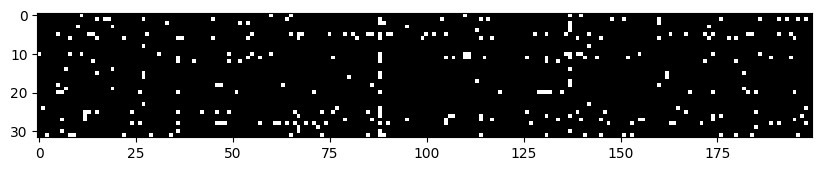

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation='nearest')

In [ ]:
h.shape

torch.Size([32, 200])

`h.view(-1)`

stretch it out into one large vector

`h.view(-1).tolist()`
to convert this one large python float list

we want logits to be roughly 0

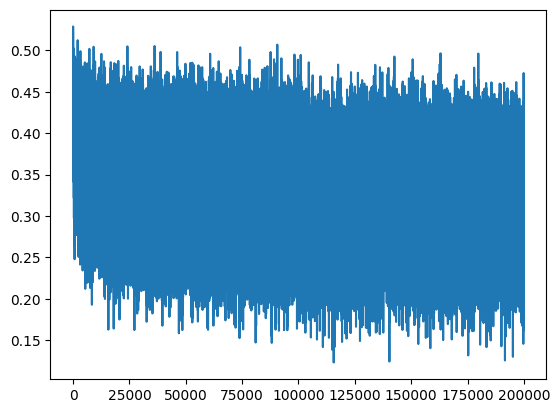

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of traning

with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(-1, n_embd * block_size)
  hpreact = embcat @ W1 + b1
  #measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val':  (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split] #The dictionary {...}[split] selects the appropriate dataset
  emb = C[x] #embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) #concatenate into (N, Block_size * n_embed)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True) ) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact) #hidden layer(# Apply activation function)
  logits = h @ W2 + b2 #output layer
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0723023414611816
val 2.1066203117370605


In [ ]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size #initialize with all
  while True:
    #forward
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    #sample from distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    #shift the context window and track
    context = context[1:] + [ix]
    out.append(ix)
    #if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

briangmyah.
shel.
bdulyah.
briyasthndra.
frazshedgelissamilsennedelssanthannchtzivsoqiamnjshugvrgthi.
jestlechretelvinnchudmuubdgghdn.
sasduf.
qheylah.
qusangelshil.
sadya.
suffurrickluprnttry.
brvekournnfrextnquxmeobhggpriczoumusziv.
hunton.
bdasirfalvindwrllw.
dettrfstts.
debirthalissa.
dvissirli.
mell.
kegbdrvy.
xavonahthanten.


We encountered a problem with the model where the 1st loss value was very high.

we modified the weights (W2) and biases (b2) of the second layer by multiple 0 and 0.01

```
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
```





* tanh function is the squashing function it take arbitrary input numbers to the range between -1 and 1.This makes it useful for normalizing neural network activations."





```
def tanh(self)

   x = self.data
   t = (math.exp(2**x) - 1 ) -(math.exp(2**x) - 1 )
   out = Value(t, (self, ), 'tanh')

   def _backward():
      self.grad += (1 - t**2) * out.grad
      out._backward = _backward
    
      return out

```

if there is t = 0 or -1 (which happens when the input approaches positive or negative infinity), the gradient would become zero, potentially causing vanishing gradient issues during backpropagation.


Batch Normalization

it made it possible to train very deep neuron net quit reliably

# loss log

**original:**

train 2.1245384216308594

val 2.168196439743042

**fix softmax confidently wrong:**

train 2.07

val 2.13

**fix tanh layer too saturated at init:**

train 2.03924298286438

val   2.1138269901275635


**add a batch norm layer**

train 2.07118821144104

val 2.1130783557891846

* Batch normalization which is one of the 1st modern innovations ==>that helped stabilized deep neural network

*

In [ ]:
# SUMMARY + PYTORCHIFYING -----------

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

#Implements a fully connected(dense)layer.
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    # Always return self.out, even if bias is None
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])



#Normalizes activations across the batch to stabilize training
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]



#Applies tanh(x), which squashes values between -1 and 1
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []



n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility


#5 Hidden Layers
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]





# layers = [
#    Linear(n_embd * block_size, n_hidden), Tanh(),
#    Linear(           n_hidden, n_hidden), Tanh(),
#    Linear(           n_hidden, n_hidden), Tanh(),
#    Linear(           n_hidden, n_hidden), Tanh(),
#    Linear(           n_hidden, n_hidden), Tanh(),
#    Linear(           n_hidden, vocab_size),
#  ]


with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True


47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors(Xb Gets minibatch from training set.)
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)  # Pass through each layer
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph (Store gradient)
  for p in parameters:
    p.grad = None # Reset gradients
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3043


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.28%
layer 5 (      Tanh): mean +0.00, std 0.65, saturated: 2.31%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 1.97%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.97%
layer 14 (      Tanh): mean +0.00, std 0.66, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

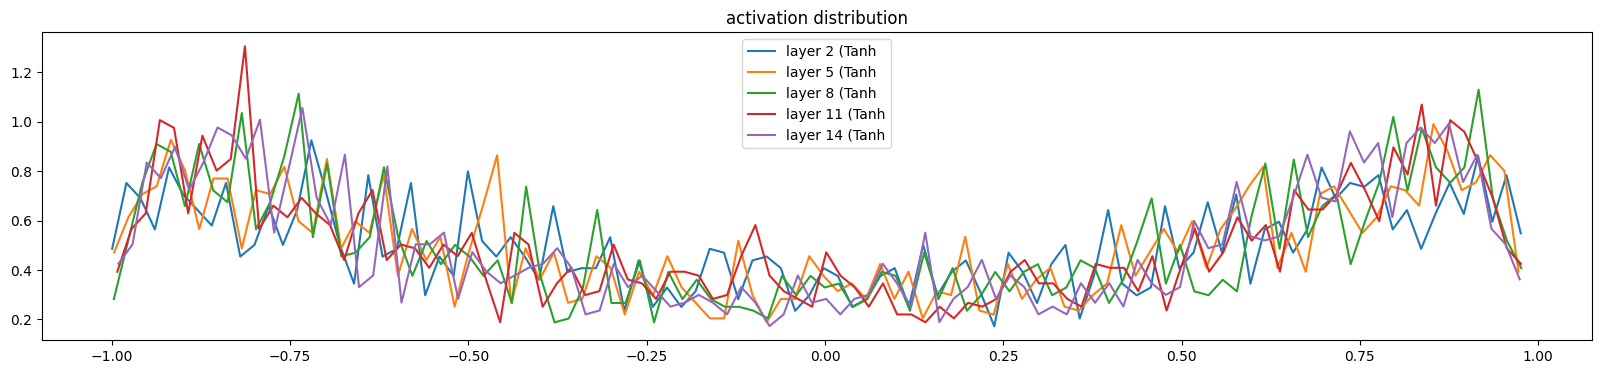

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.147536e-03
layer 5 (      Tanh): mean +0.000000, std 1.901361e-03
layer 8 (      Tanh): mean -0.000000, std 1.820469e-03
layer 11 (      Tanh): mean -0.000000, std 1.758239e-03
layer 14 (      Tanh): mean -0.000000, std 1.835955e-03


Text(0.5, 1.0, 'gradient distribution')

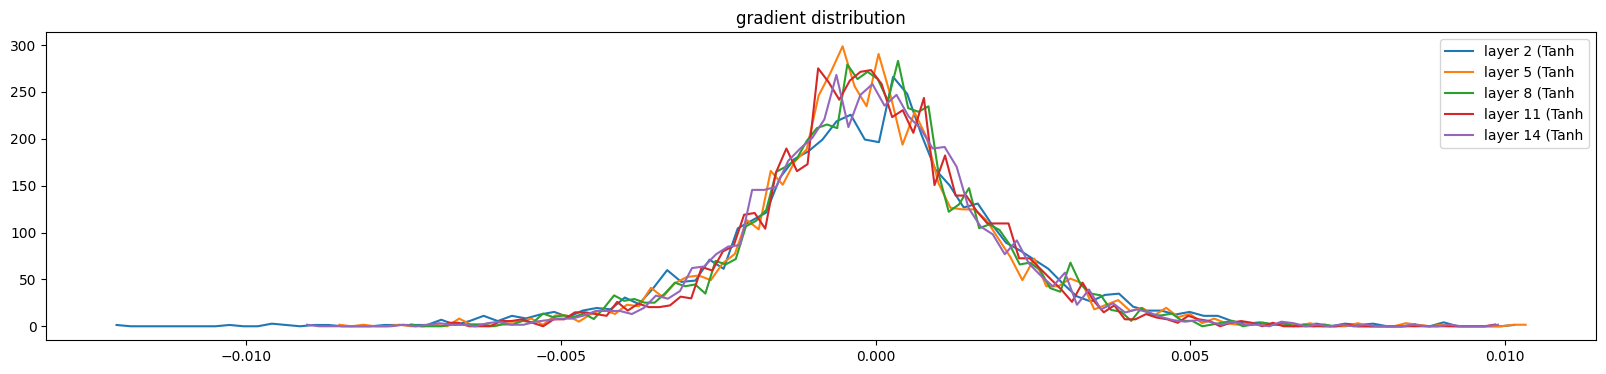

In [ ]:
# visualize histograms(forward pass)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 7.168573e-03 | grad:data ratio 7.161360e-03
weight  (30, 100) | mean -0.000040 | std 7.702153e-03 | grad:data ratio 4.241531e-02
weight (100, 100) | mean -0.000037 | std 5.906821e-03 | grad:data ratio 5.737851e-02
weight (100, 100) | mean -0.000018 | std 4.923237e-03 | grad:data ratio 4.779262e-02
weight (100, 100) | mean -0.000019 | std 4.787974e-03 | grad:data ratio 4.697947e-02
weight (100, 100) | mean +0.000104 | std 4.769925e-03 | grad:data ratio 4.712082e-02
weight  (100, 27) | mean +0.000058 | std 9.426321e-03 | grad:data ratio 9.036734e-02


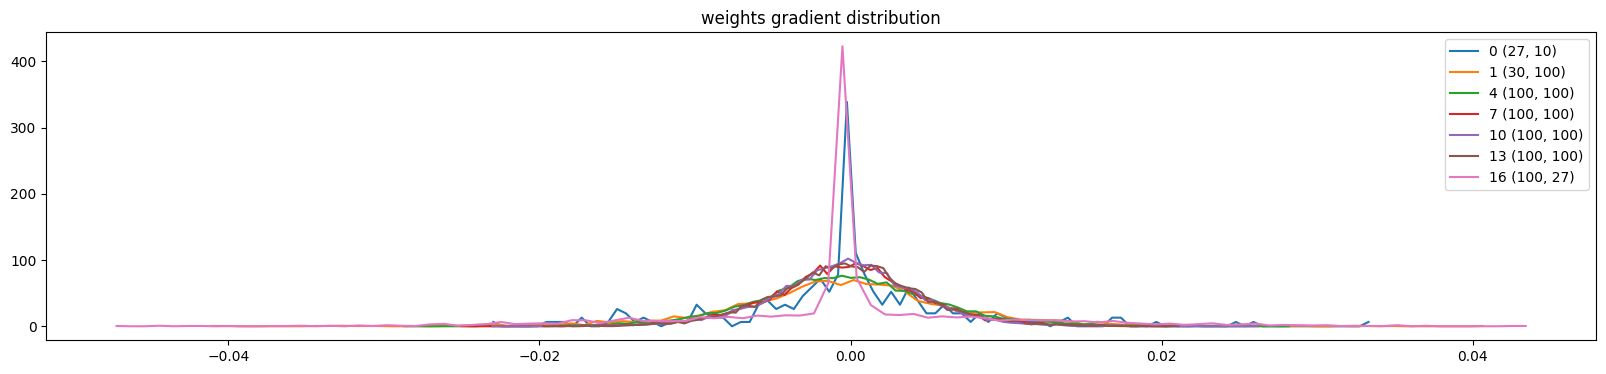

In [ ]:
# visualize histograms(backward pass)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

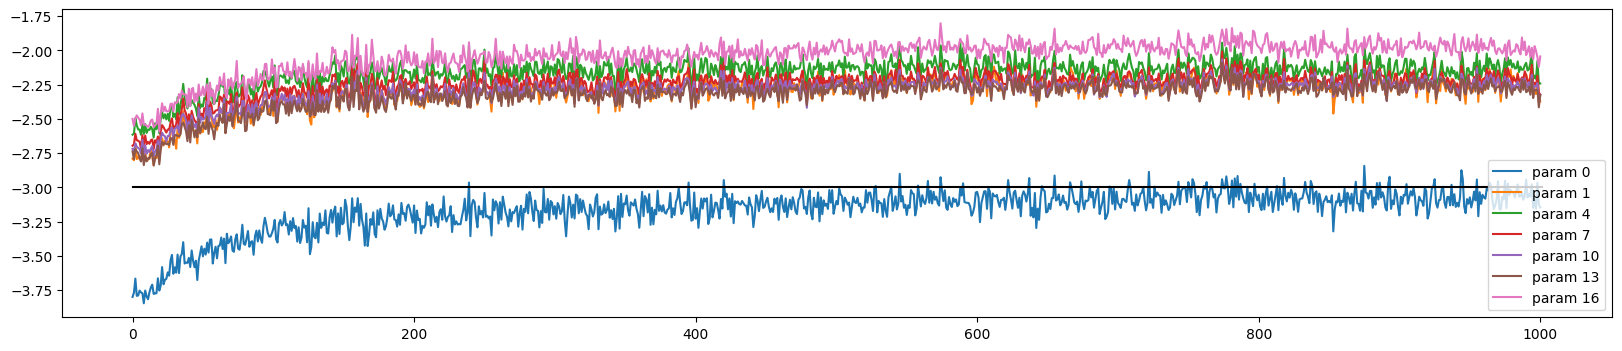

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.388847827911377
val 2.386774778366089


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.
mmyan.
seel.
ndhayla.
remhrstendrleg.
azered.
eliie.
miloelleieliean.
nar.
katzion.
kamin.
shubvrgshiriel.
kinie.
jeliqxnthuifiu.
zen.
dar.
yahli.
ehs.
kayjahstoyan.
hiliaa.
